# Management and Analysis of Physics Dataset - mod. B

### Davide Maniscalco*



*Expanded and modified version of the previous notebook from Maniscalco, Pompeo.

## Session II

### PART A

**Describe in a schematic way the GRID and the Cloud layers in a distributed system commenting on the differences. (max 1 page)**

> The term GRID refers to a distributed computing architecture where machines from different locations are connected to each others and share resources in order to achieve a common goal. The interconnection between these machines makes it possible for the whole system to have much higher computational capabilities while at the same time not requiring hardware that may be too expensive.
The GRID is a set of code that works on several layers. The **fabric layer** combines the set of hardware resources, networks and code repositories that in a way constitute the physical backbone of the GRID itself. The **connectivity layer**, on the other hand, is a software layer where communication and authentication protocols are implemented; authentication and authorization are in fact key factors for an efficient exploitation of this architecture, which is why it is crucial to devolve a layer for security and traceability of operations. In the **resource layer**, again a software one, more specific protocols are defined: procedures such as publication of data and access to it, prioritization of the jobs, monitoring of the resources that are being used and even payment for the services are handled. Interactions between GRID resources are dealt with in the **collective layer**, which is of crucial importance in combining all together those services that are not necessarily specific to a single resource. Finally, the **application layer** is where any user application built on top of the mentioned protocols resides: in a way, it is the software that allows individual access to the GRID.
>
> In parallel with the development of the GRID especially in the scientific field, also the concept of Cloud came about. Clouds are large pools of computing or storage resources which can be accessed via standard protocols (for example, the Internet) through an abstract interface: in a way they are the commercial answer to the GRID. Clouds are usually composed of 4 layers and in some cases they have a broad difference with the GRID architecture. The first one is the **fabric** and it is basically the same as the one in the GRID, as also the hardware components do not differ extensively. Then, there is the **unified resource layer**, which contains resources that have been abstracted and prepared for high level applications. In contrast with the GRID, resources are managed centrally and they are virtualized and integrated between them, without the need of a dedicated layer for this purpose (like the connectivity layer in the GRID). Afterwards, the **platform layer** can be found, which provides the user with a development platform and where the middleware is located, enabling communication and management of data; in the Cloud resources are in fact provided according to the user requirements ($\textit{on-demand}$), while in the GRID machines are just assigned one of the subtasks in which the main task gets divided. The last layer of the Cloud is the **application layer**, containing the end-software running in the cloud itself, not unlike its GRID corresponding.
>
> The differences we have highlighted so far are the ones mainly pertaining to the layers in which the two entities are divided, so mostly related to their architecture. While other significant discrepancies do exist (just to cite an example, the GRID resources are distributed, while the Cloud is a client-server structure) it should be kept in mind that these are not two completely separate worlds. Actually, thanks to some of the most recent technological developments, experts are trying to move the GRID to the Cloud, employing high-speed networks that make data locality a less stringent requirement or storing data in $\textit{datalakes}$, large and flexible storage units. 

### PART B

### 1) Create your cluster with fixed number of workers, equal to 2

As preliminary operations, in a terminal window we run the command `dask-scheduler`, we retrieve the Client name and, in a different window, we run `dask-worker 10.190.1.68:8786 --nprocs 2`, where 10.190.1.68 is the client number and the option `--nprocs` indicates how many workers we are employing (at this time, 2 of them and without creating a multiple-machine cluster).


In [5]:
client = Client("192.168.1.23:8786")
client

Client Scheduler: tcp://192.168.1.23:8786 Dashboard: http://192.168.1.23:8787/status,Cluster Workers: 2 Cores: 8 Memory: 15.58 GB


We now import all the packages that we will need throughout our analysis.

In [3]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import dask_ml
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import MinMaxScaler
from dask_ml.wrappers import Incremental
from sklearn.neural_network import MLPClassifier
from dask_ml.wrappers import ParallelPostFit
from timeit import default_timer as tic
from distributed import Client

%matplotlib inline

### 2) Load the remote dataset available at the link

We now create a DASK dataframe by remotely accessing a dataset containing handwritten characters from a to z; the images consist of an array in which each column contains a pixel value of a 28x28 image in grayscale format.

In [6]:
df = dd.read_csv("https://www.dropbox.com/s/75aqeywzxsu6hqt/dataset_sampled_handwritten.csv?dl=1")
df.head()  #just to explore the dataset

,letter,label,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,pixel_784
0,t,19,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,w,22,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,w,22,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,e,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3) Count the number of examples for each alphabet character and plot them

We want to know the number of examples for each letter; we will also display the occurences in a barplot. It should be noted that since we are working in parallel and the dataframe is created with DASK, it is virtualized and the `.compute()` attribute needs to be added, even if the `delayed()` function has not been invoked esplicitly.

In [7]:
letter_counts = df.groupby(["letter"])["letter"].count().compute()

letter_counts

letter
a    1871
b    1163
c    3201
d    1349
e    1606
f     134
g     768
h     972
i     154
j    1179
k     716
l    1510
m    1608
n    2578
o    7863
p    2588
q     791
r    1556
s    6400
t    2942
u    3868
v     571
w    1497
x     845
y    1439
z     831
Name: letter, dtype: int64

We now display the values in a barplot.

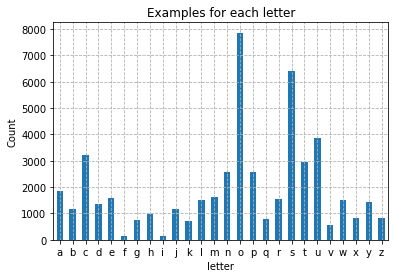

In [8]:
letter_counts.plot(kind='bar', title = "Examples for each letter")
plt.grid(True,ls='--')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

### 4) Record the time necessary to accomplish point 3, do different repartitions of data (use 3-4 different numbers of partitions). Record the new execution times and explain their behaviour

We are now interested in studying the execution time to accomplish Point (3) as the number of repartitions of data made by DASK changes. In the following, we will indicate the number of involved workers using the variable $n$. For each number of workers and for each partition, 10 time measurements are made.

In [9]:
partitions = [1,2,5,10,20,50]  #we also include npartitions=2 to compute its timing
iterations = 10

In [12]:
#loading of the already produced file
list_of_timelist2 = np.loadtxt('./dati/list_of_timelist_2.txt')

In [ ]:
# computation (valid for any number of workers)
list_of_timelist = []

for ii in range(iterations):
    print('Iteration: ',ii)
    timelist = []
    for num in partitions:
        df_tmp = df.repartition(npartitions=num)
        start = time.time()
        letter_counts = df_tmp.groupby(["letter"])["letter"].count().compute()
        end = time.time() - start
        timelist.append(end)
    list_of_timelist.append(timelist)

In below are shown all the measurement for the case $n=2$. Data are not enough to perform a statistical analysis, but it can be seen that they distribute randomly, for all the number of partitions.

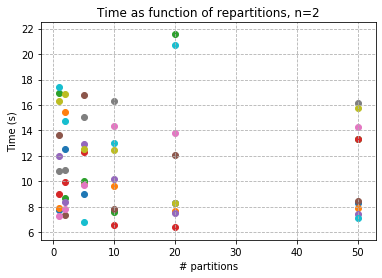

In [16]:
#  n = 2, total plot
for ii in range(iterations):    
    plt.scatter(partitions, list_of_timelist2[ii])
    plt.title("Time as function of repartitions, n=2")
    plt.xlabel("# partitions")
    plt.ylabel("Time (s)")
    plt.grid(True, ls="--")
plt.show()

In below are shown the ten plots of the ten series of measures taken. This is to show an apparent lack of correlation between the time measurements of each series.

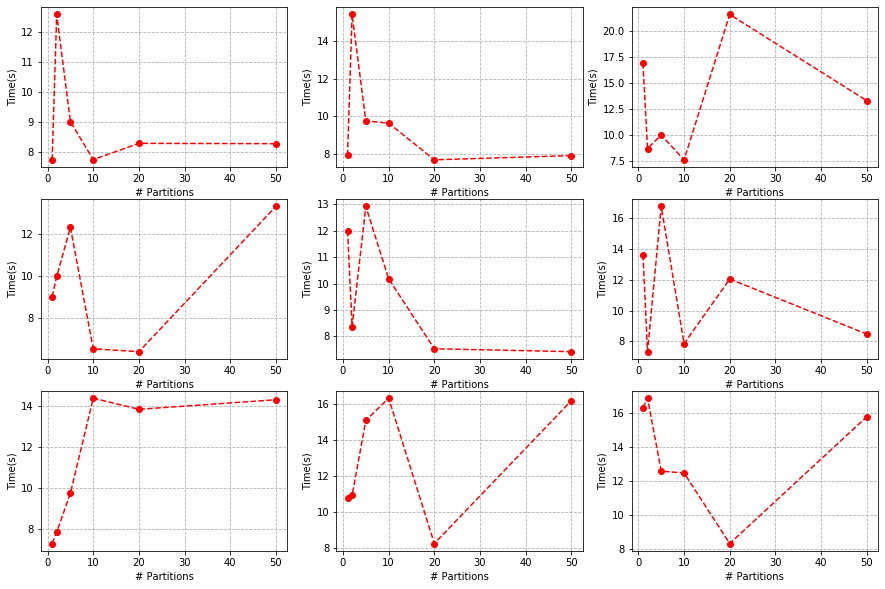

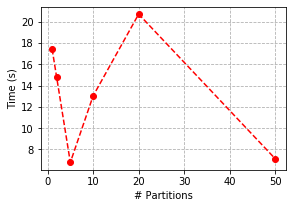

In [17]:
# n = 2, plot of each set of measurements
fig, axs = plt.subplots(3, 3, figsize=(15,10))
for ii in range(iterations-1):
    axs[ii//3, ii%3].plot(partitions, list_of_timelist2[ii],"ro--")
    axs[ii//3, ii%3].grid(ls="--")
    axs[ii//3, ii%3].set_xlabel('# Partitions')
    axs[ii//3, ii%3].set_ylabel('Time(s)')
plt.figure(figsize=(4.4,3))
plt.plot(partitions, list_of_timelist2[9], "ro--")
plt.xlabel("# Partitions")
plt.ylabel("Time (s)")
plt.grid(True, ls="--")

The number of partitions seems to have no influence in clearly defining a trend for the execution time to count the number of occurences for each letter. This can be seen both by the fact that the values change (even drastically, at times) every time the program is run and because the lines we obtain goes up and down in no clear fashion. 
An hypothesis for this could be that the dataset is not big enough (about 90 MB, everything could have been done locally) to be suitable for a parallel approach, and the fact that we do not know the other operations performed by the cluster, that cause unpredictable overheads.

### 5) Filter the data in order to get a subsampled dataset that contains only rows for character ‘a’ and ‘z’. Print the computation graph and comment the behavior.

We now trim our dataset to get a subsample only containing letters $a$ and $z$.

In [10]:
mask = ['a','z']
condition = df['letter'].isin(mask)
df_filtered = df[condition]

df_filtered.head()  #checking if the selection worked properly

,letter,label,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,pixel_784
4,a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,z,25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69,a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77,a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


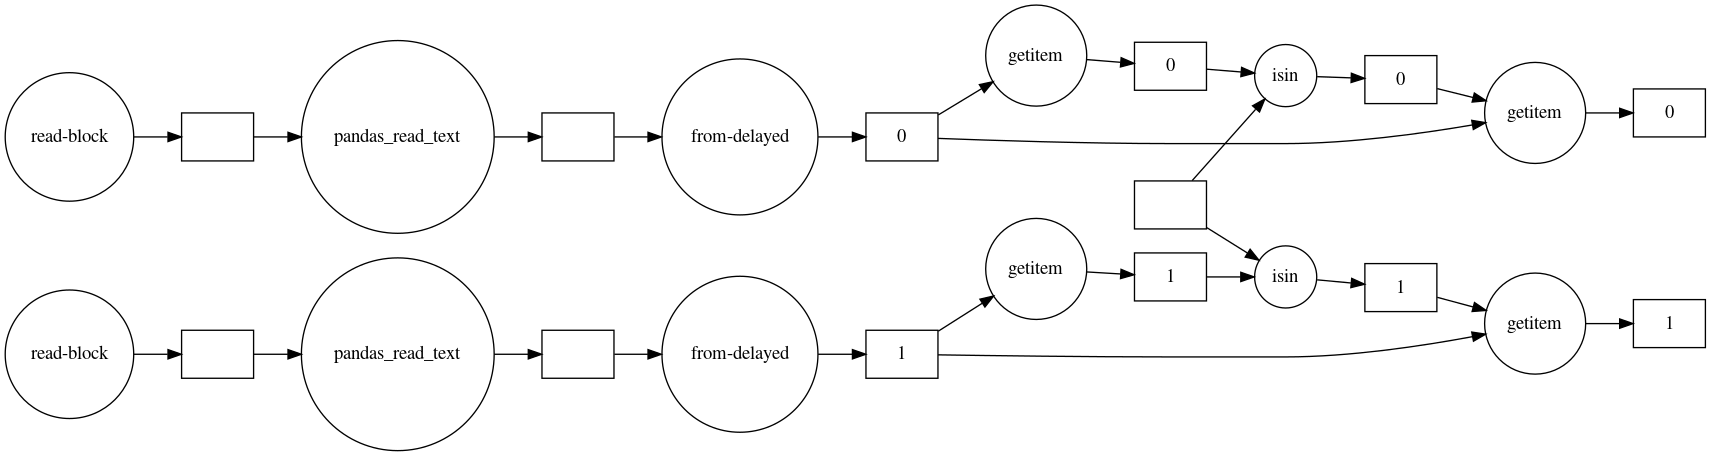

In [11]:
df_filtered.visualize(rankdir='LR')

The chunks in which this graph is divided represent the different number of partitions (in this case equal to 2) and not the number of workers. We can clearly see that in each partition the followed workflow is exactly the same, proceeding in parallel; the indexes 0 and 1 are once again used to label the partitions.

### 6) Take the subsampled dataset obtained in point 5 divide it in training (80%) and test (20%) sets.

The following cell is used to prepare our trimmed dataset for the Machine Learning classification algorithm: we consider the pixel values as our instances (`X`), while the letter they correspond to acts as a label (`y`). Both have to be converted into a dask array; then we properly split them in training set and test set, using an 80%-20% balance, which is customary in ML. 

In [7]:
X= df_filtered.iloc[:,2:].to_dask_array(True) 
y= df_filtered["label"].to_dask_array(True)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2)

### 7) Use the MinMaxScaler with IncrementalLearning, MLPClassifier and ParallelPostFit in order to training and test a simple neural network over the cluster. Take in consideration the reached accuracy and the execution time.

The following rescales our data.

With the function `MLPClassifier()` we define our classification algorithm; `Incremental()` makes it possible for the estimator to work in parallel (training made not looking at the whole dataset in a once), while `ParallelPostFit()` is used to perform predictions, once again in a parallel architecture.

In [16]:
#apply the transformer: rescaling in the interval [0,1]
transformer = MinMaxScaler(feature_range=(0, 1), copy=True)
transformer.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [8]:
estimator = MLPClassifier(random_state=42, 
                          max_iter=1000, 
                          hidden_layer_sizes=(200, 200), 
                          activation='relu', 
                          solver='adam', alpha=0.0001, 
                          batch_size='auto', 
                          learning_rate_init=0.001, 
                          shuffle=True, 
                          tol=0.0001, 
                          validation_fraction=0.1)

The whole process is repeated $10$ times. Accuracy and two time measurements were computed and stored in files that will be loaded in below for the analysis.

In [ ]:
time_it = 10
times_2 = []
total_times_2 = []
accuracy_2 = []

for tt in range(time_it):
    
    tstart = tic()
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
    transformer = MinMaxScaler(feature_range=(0, 1), copy=True)
    transformer.fit(X_train)
    X_train = transformer.transform(X_train)
    X_test = transformer.transform(X_test)

    t1 = tic()
    
    clf = Incremental(estimator)
    clf.fit(X_train, y_train, classes=[0, 25]) 
    preds = ParallelPostFit(estimator=clf.estimator_,scoring='accuracy')
    
    t2 = tic()
    
    times_2.append(t2-t1)
    total_times_2.append(t2-tstart)
    accuracy_2.append(dask_ml.metrics.accuracy_score(y_test, preds.predict(X_test)))

    print('Total time at iteration '+str(tt)+' '+str(t2-tstart))
    
print("Accuracy: "+str(dask_ml.metrics.accuracy_score(y_test, preds.predict(X_test))))
print("Time: "+str(t2-t1)+"s")

The analysis is performed in point 8, where data taken for $n=2$ are analyzed together with data taken for the other numbers of workers.

### 8) Repeat from point 1 to point 7 changing the number of workers to 4, 6, 8, 10 (larger number of workers must be implemented with multiple machines ( >= 6 )). Compare the results and the times and explain the behaviour

In [12]:
workers = np.array([2,4,6,8,10],dtype=int)

Repetition of points 1,2,3 is trivial, and the result is the same as before. 

#### Repetition of point 4
The code seen before was re-run with the indicated numbers of workers and results were saved. Here below the loading of the results and the images of the clients. Clusters were created always with a number of cores twice than the number of workers.

In [13]:
# data loading
list_of_timelist4 = np.loadtxt('./dati/list_of_timelist_4.txt')
list_of_timelist6 = np.loadtxt('./dati/list_of_timelist_6.txt')
list_of_timelist8 = np.loadtxt('./dati/list_of_timelist_8.txt')
list_of_timelist10 = np.loadtxt('./dati/list_of_timelist_10.txt')
total = np.stack((list_of_timelist2, list_of_timelist4, list_of_timelist6, 
                  list_of_timelist8, list_of_timelist10),axis=0)

In [123]:
client = Client("10.190.1.82:8786")
client

Client Scheduler: tcp://10.190.1.82:8786 Dashboard: http://10.190.1.82:8787/status,Cluster Workers: 4 Cores: 8 Memory: 16.31 GB


In [81]:
client = Client("10.190.1.82:8786")
client

Client Scheduler: tcp://10.190.1.82:8786 Dashboard: http://10.190.1.82:8787/status,Cluster Workers: 6 Cores: 12 Memory: 24.46 GB


In [103]:
client = Client("10.190.1.82:8786")
client

Client Scheduler: tcp://10.190.1.82:8786 Dashboard: http://10.190.1.82:8787/status,Cluster Workers: 8 Cores: 16 Memory: 32.62 GB


In [112]:
client = Client("10.190.1.82:8786")
client

Client Scheduler: tcp://10.190.1.82:8786 Dashboard: http://10.190.1.82:8787/status,Cluster Workers: 10 Cores: 20 Memory: 40.77 GB


In below are plotted all the time measurements as a function of the number of partitions for all the values of $n$ considered. As it can be seen, as in the case $n=2$ data distributes randomly because of the aforementioned effects: hence at a first sight it seems that the number of workers doesn't change the aforementioned behaviour.

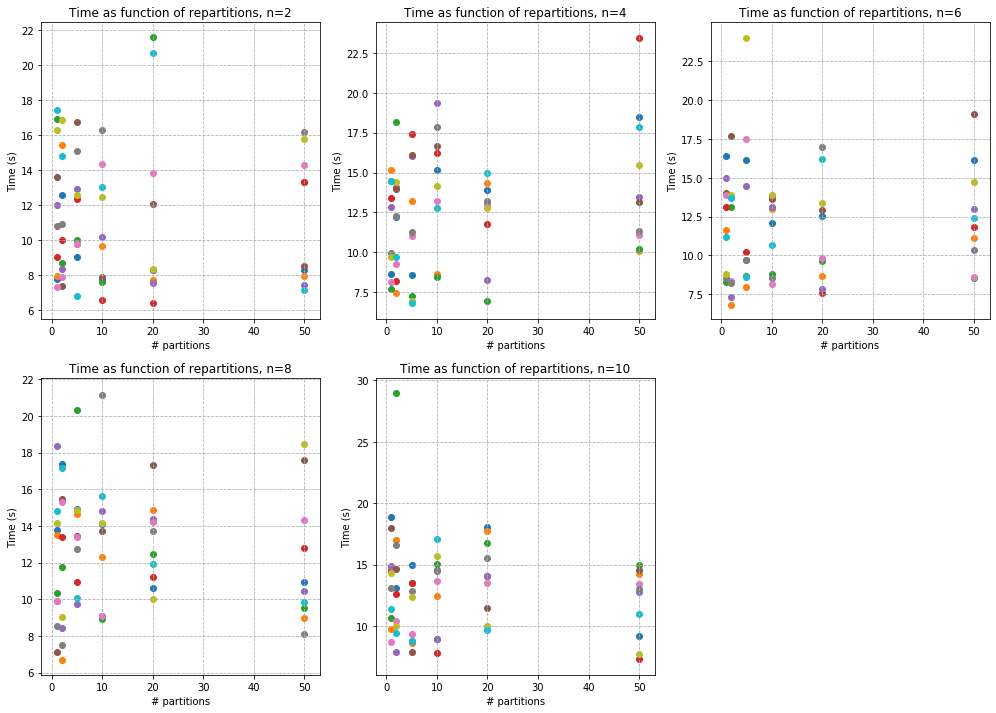

In [33]:
# plot of all the data
fig = plt.figure(1, figsize = (17,12))
gridspec.GridSpec(2,3)

plt.subplot2grid((2,3), (0,0))
for ii in range(iterations):    
    plt.scatter(partitions, list_of_timelist2[ii])
    plt.title("Time as function of repartitions, n=2")
    plt.xlabel("# partitions")
    plt.ylabel("Time (s)")
    plt.grid(True, ls="--")

plt.subplot2grid((2,3), (0,1))
for ii in range(iterations):    
    plt.scatter(partitions, list_of_timelist4[ii])
    plt.title("Time as function of repartitions, n=4")
    plt.xlabel("# partitions")
    plt.ylabel("Time (s)")
    plt.grid(True, ls="--")

plt.subplot2grid((2,3), (0,2))
for ii in range(iterations):    
    plt.scatter(partitions, list_of_timelist6[ii])
    plt.title("Time as function of repartitions, n=6")
    plt.xlabel("# partitions")
    plt.ylabel("Time (s)")
    plt.grid(True, ls="--") 

plt.subplot2grid((2,3), (1,0))
for ii in range(iterations):    
    plt.scatter(partitions, list_of_timelist8[ii])
    plt.title("Time as function of repartitions, n=8")
    plt.xlabel("# partitions")
    plt.ylabel("Time (s)")
    plt.grid(True, ls="--")

plt.subplot2grid((2,3), (1,1))
for ii in range(iterations):    
    plt.scatter(partitions, list_of_timelist10[ii])
    plt.title("Time as function of repartitions, n=10")
    plt.xlabel("# partitions")
    plt.ylabel("Time (s)")
    plt.grid(True, ls="--")

Now for every $n$ it are calculated and plotted the average times for all number of partitions.

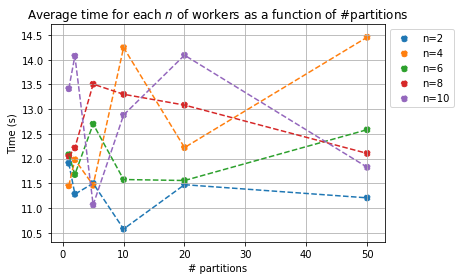

In [106]:
plt.plot(partitions, means[0,:], ls='--')
plt.plot(partitions, means[1,:], ls='--')
plt.plot(partitions, means[2,:], ls='--')
plt.plot(partitions, means[3,:], ls='--')
plt.plot(partitions, means[4,:], ls='--')

plt.scatter(partitions, means[0,:], label='n=2',ls='--')
plt.scatter(partitions, means[1,:], label='n=4',ls='--')
plt.scatter(partitions, means[2,:], label='n=6',ls='--')
plt.scatter(partitions, means[3,:], label='n=8',ls='--')
plt.scatter(partitions, means[4,:], label='n=10',ls='--')

plt.xlabel('# partitions')
plt.ylabel('Time (s)')
plt.title('Average time for each $n$ of workers as a function of #partitions')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid()

For sure averages of ten elements are not enough for a statistical analysis, but the shapes of this lines give a further confirmation of the fact that the number of workers has a limited effect on the behaviour, because of the aforementioned affects. However, one can hazard a hypotesis about the case $n=2$: in almost all cases (all but $n=1$ and $n=5$, the unique number of partitions not divisible for $2$) on average, it is the situation where less time is required: maybe, because of the small size of the dataset, the overheads due to a larger cluster are decisive.

#### Repetition of point 7
Repetition of points 5,6 is trivial: please just refer to the previous lines of code. Point 7 was repeated taking 10 time and accuracy measurements for each number of workers $n$. Data are now loaded and analyzed.

In [49]:
# loading data
accuracy2 = np.genfromtxt('./dati/accuracy2.txt')
accuracy4 = np.genfromtxt('./dati/accuracy4.txt')
accuracy6 = np.genfromtxt('./dati/accuracy6.txt')
accuracy8 = np.genfromtxt('./dati/accuracy8.txt')
accuracy10 = np.genfromtxt('./dati/accuracy10.txt')
times2 = np.genfromtxt('./dati/times_2.txt')
times4 = np.genfromtxt('./dati/times_4.txt')
times6 = np.genfromtxt('./dati/times_6.txt')
times8 = np.genfromtxt('./dati/times_8.txt')
times10 = np.genfromtxt('./dati/times_10.txt')
totaltimes2 = np.genfromtxt('./dati/total_times_2.txt')
totaltimes4 = np.genfromtxt('./dati/total_times_4.txt')
totaltimes6 = np.genfromtxt('./dati/total_times_6.txt')
totaltimes8 = np.genfromtxt('./dati/total_times_8.txt')
totaltimes10 = np.genfromtxt('./dati/total_times_10.txt')

Here are shown all the measurement of the accuracy, of the time, and of the total time as a function of the number of workers. To see precisely what does time and total time are measure of, see the cell above; essentialy the first measures the time needed for the preparation of the data (splitting, tranformation); while the last measures the time needed for the first operation plus the true fitting and predicting operations. In the graphics about time and total time, $full$ circles represents points of measurements whose relative accuracy is $>0.95$, while $empty$ points measurements whose accuracy is $<0.95$.

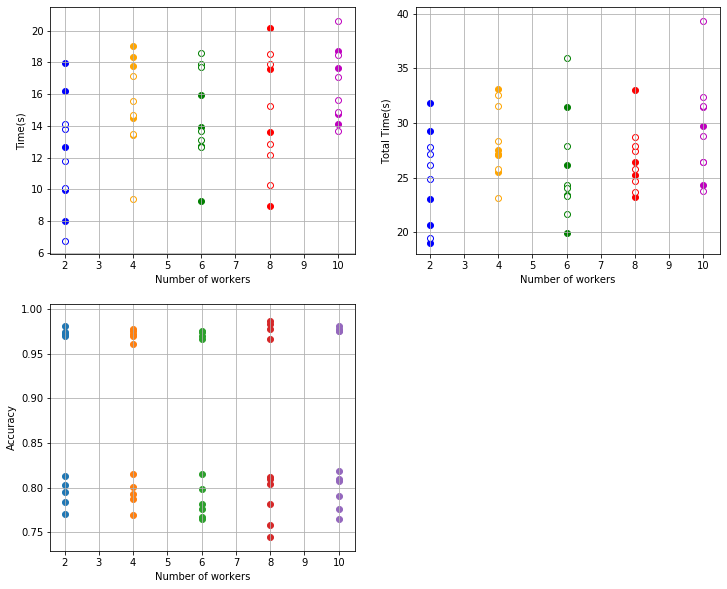

In [50]:
# plot of all the data
fig = plt.figure(1, figsize = (12,10))
gridspec.GridSpec(2,2)

plt.subplot2grid((2,2), (1,0))
plt.scatter(np.linspace(workers[0],workers[0],10), accuracy2)
plt.scatter(np.linspace(workers[1],workers[1],10), accuracy4)
plt.scatter(np.linspace(workers[2],workers[2],10), accuracy6)
plt.scatter(np.linspace(workers[3],workers[3],10), accuracy8)
plt.scatter(np.linspace(workers[4],workers[4],10), accuracy10)
plt.xlabel('Number of workers')
plt.ylabel('Accuracy')
plt.grid()

plt.subplot2grid((2,2), (0,0))
plt.scatter(np.linspace(workers[0],workers[0],len(times2[accuracy2 > 0.95])), times2[accuracy2 > 0.95],color='blue')
plt.scatter(np.linspace(workers[0],workers[0],len(times2[accuracy2 < 0.95])), times2[accuracy2 < 0.95], edgecolor='blue',color='white')
plt.scatter(np.linspace(workers[1],workers[1],len(times4[accuracy4 > 0.95])), times4[accuracy4 > 0.95],color='orange')
plt.scatter(np.linspace(workers[1],workers[1],len(times4[accuracy4 < 0.95])), times4[accuracy4 < 0.95], edgecolor='orange',color='white')
plt.scatter(np.linspace(workers[2],workers[2],len(times6[accuracy6 > 0.95])), times6[accuracy6 > 0.95],color='green')
plt.scatter(np.linspace(workers[2],workers[2],len(times6[accuracy6 < 0.95])), times6[accuracy6 < 0.95], edgecolor='green',color='white')
plt.scatter(np.linspace(workers[3],workers[3],len(times8[accuracy8 > 0.95])), times8[accuracy8 > 0.95],color='red')
plt.scatter(np.linspace(workers[3],workers[3],len(times8[accuracy8 < 0.95])), times8[accuracy8 < 0.95], edgecolor='red',color='white')
plt.scatter(np.linspace(workers[4],workers[4],len(times10[accuracy10 > 0.95])), times10[accuracy10 > 0.95],color='m')
plt.scatter(np.linspace(workers[4],workers[4],len(times10[accuracy10 < 0.95])), times10[accuracy10 < 0.95], edgecolor='m',color='white')
plt.xlabel('Number of workers')
plt.ylabel('Time(s)')
plt.grid()

plt.subplot2grid((2,2), (0,1))
plt.scatter(np.linspace(workers[0],workers[0],len(totaltimes2[accuracy2 > 0.95])), totaltimes2[accuracy2 > 0.95],color='blue')
plt.scatter(np.linspace(workers[0],workers[0],len(totaltimes2[accuracy2 < 0.95])), totaltimes2[accuracy2 < 0.95], edgecolor='blue',color='white')
plt.scatter(np.linspace(workers[1],workers[1],len(totaltimes4[accuracy4 > 0.95])), totaltimes4[accuracy4 > 0.95],color='orange')
plt.scatter(np.linspace(workers[1],workers[1],len(totaltimes4[accuracy4 < 0.95])), totaltimes4[accuracy4 < 0.95], edgecolor='orange',color='white')
plt.scatter(np.linspace(workers[2],workers[2],len(totaltimes6[accuracy6 > 0.95])), totaltimes6[accuracy6 > 0.95],color='green')
plt.scatter(np.linspace(workers[2],workers[2],len(totaltimes6[accuracy6 < 0.95])), totaltimes6[accuracy6 < 0.95], edgecolor='green',color='white')
plt.scatter(np.linspace(workers[3],workers[3],len(totaltimes8[accuracy8 > 0.95])), totaltimes8[accuracy8 > 0.95],color='red')
plt.scatter(np.linspace(workers[3],workers[3],len(totaltimes8[accuracy8 < 0.95])), totaltimes8[accuracy8 < 0.95], edgecolor='red',color='white')
plt.scatter(np.linspace(workers[4],workers[4],len(totaltimes10[accuracy10 > 0.95])), totaltimes10[accuracy10 > 0.95],color='m')
plt.scatter(np.linspace(workers[4],workers[4],len(totaltimes10[accuracy10 < 0.95])), totaltimes10[accuracy10 < 0.95], edgecolor='m',color='white')
plt.xlabel('Number of workers')
plt.ylabel('Total Time(s)')
plt.grid()

As it is possible to see, both time measurements have a small variability, concerning the same number of workers, and they seem not vary significantly between the various numbers of workers. Accuracy, instead, shows a stranger behaviour, with a gap between two group of values. There is not a clear correlation between accuracy and time, with this few data.

Finally, it is shown the table of the mean values of the three aforementioned quantities for all the numbers of workers.

In [51]:
# mean values table
mean_accuracy = np.array((np.mean(accuracy2), np.mean(accuracy4),np.mean(accuracy6) ,np.mean(accuracy8),np.mean(accuracy10)))
mean_time = np.array((np.mean(times2), np.mean(times4),np.mean(times6) ,np.mean(times8),np.mean(times10)))
mean_total_time = np.array((np.mean(totaltimes2), np.mean(totaltimes4),np.mean(totaltimes6) ,np.mean(totaltimes8),np.mean(totaltimes10)))
total_totable = np.vstack((workers, mean_accuracy, mean_time, mean_total_time)).T
table = pd.DataFrame(total_totable, columns=['Workers','Accuracy','Time(s)','Total time (s)'])
table = table.style.hide_index()
table

Workers,Accuracy,Time(s),Total time (s)
2,0.883615,12.1287,24.9216
4,0.882255,15.333,28.1697
6,0.85915,14.5523,25.8001
8,0.862477,14.7275,26.6138
10,0.868022,16.5641,29.4118


The mean value may be a good estimator for time measurements, while it wouldn't be explicative about the starnge behaviour of the accuracy. The unpresence of a significative variability of the measurements, changing the number of workers, is probably due to the too small size of the dataset. Bigger clusters seem to lead, on average, to bigger times, that wouldn't be surprising; only the case $n=4$ violates this behaviour.

### 9) Use the distributed Tensorflow. Use the MinMaxScaler with Convolutional Neural Network that you can find in the function `def build_deep_cnn_neural_network()` on the Notebook "Distributed Deep Learning on CPU-GPU". Pay attention to the input_shape

In [39]:
from dask.distributed import Client
from dask_ml.datasets import make_classification
from dask_tensorflow import start_tensorflow

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout

from sklearn.metrics import accuracy_score

Using TensorFlow backend.


We invoke `TensorFlow` and we set the number of workers equal to 4, using only one machine.

In [4]:
from dask.distributed import Client
from dask_tensorflow import start_tensorflow

In [6]:
tf_spec, dask_spec = start_tensorflow(client, ps=2, worker=2)

We redefine the trimmed dataset which will be used for the classification algorithm in a distributed Convolutional Neural Network.

In [27]:
mask = ['a','z']
condition = df['letter'].isin(mask)
df_filtered = df[condition]

X= df_filtered.iloc[:,2:].values.compute()
y= df_filtered["label"].values.compute()

We perform some data preprocessing: the label for letter $z$ needs to be changed from 25 to 1 (because of the algorithm) and since we are employing a CNN, the columns representing the pixels need to be reshaped from a $1\times784$ array to a $28\times28$ matrix. 

In [28]:
y[y==25] = 1

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2)

transformer = MinMaxScaler(feature_range=(-1,1),copy=True)
transformer.fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

X_train, X_test = X_train.reshape((len(X_train), 28,28, 1)),  X_test.reshape((len(X_test), 28,28, 1))

W0309 12:34:13.072538 140264297277184 _split.py:454] Mixture of types in 'arrays'. Falling back to scikit-learn.


Building of the neural network:

In [29]:
def build_deep_cnn_neural_network():
    
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(3,3), name='c', strides=(1, 1), padding='valid', activation='relu', input_shape=(28,28,1)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', name='d'))
    model.add(Dense(32, activation='relu', name='d1'))
    model.add(Dense(1, activation='sigmoid', name='d2'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

With the implemented function, we run the algorithm for 10 epochs.

In [30]:
model = build_deep_cnn_neural_network()

model.fit(X_train, y_train, verbose=1, epochs=10, batch_size=32)
#print(model.predict(X_test))
scores = model.evaluate(X_test,y_test, verbose=1)
print("Accuracy: "+str(scores[1]))

W0309 12:34:20.915815 140264297277184 deprecation_wrapper.py:119] From /home/davide/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0309 12:34:21.114193 140264297277184 deprecation_wrapper.py:119] From /home/davide/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0309 12:34:21.213279 140264297277184 deprecation_wrapper.py:119] From /home/davide/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0309 12:34:21.471433 140264297277184 deprecation_wrapper.py:119] From /home/davide/anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0309 12

Epoch 1/10
2161/2161 [==============================] - 22s 10ms/step - loss: 0.1150 - acc: 0.9621
Epoch 2/10
2161/2161 [==============================] - 23s 11ms/step - loss: 0.0286 - acc: 0.9894
Epoch 3/10
2161/2161 [==============================] - 20s 9ms/step - loss: 0.0024 - acc: 0.9981
Epoch 4/10
2161/2161 [==============================] - 19s 9ms/step - loss: 3.7718e-04 - acc: 1.0000
Epoch 5/10
2161/2161 [==============================] - 19s 9ms/step - loss: 1.7903e-04 - acc: 1.0000
Epoch 6/10
2161/2161 [==============================] - 17s 8ms/step - loss: 1.1939e-04 - acc: 1.0000
Epoch 7/10
2161/2161 [==============================] - 20s 9ms/step - loss: 8.9334e-05 - acc: 1.0000
Epoch 8/10
2161/2161 [==============================] - 20s 9ms/step - loss: 7.0854e-05 - acc: 1.0000
Epoch 9/10
2161/2161 [==============================] - 19s 9ms/step - loss: 5.7576e-05 - acc: 1.0000
Epoch 10/10
541/541 [==============================] - 1s 1ms/step
Accuracy: 1.0


We obtain extremely satisfactory values for accuracies; it is somewhat alarming to obtain so many 1s (perfect accuracy), but these values are computed on the test set, so there should be no risk of overfitting.